# Google traces


In [6]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import os

In [7]:
datadir = '/home/aakahlow/GTraces/gem5/gtraces-results/'

In [32]:
def getStat(filename, stat):
    #filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    #print(stat)
    #print(filename)
    try:
        with open(filename) as f:
            readlines = f.readlines()
            for l in readlines:
                if stat in l:
                    return l
            return 0.0 #for cases where stat was not found
    except: #for cases where the file was not found
        return 0.0

In [33]:
Stats = ['system.mem_ctrl.dram.avgRdBW', 'system.mem_ctrl.dram.avgWrBW', 'system.mem_ctrl.dram.busUtil']

#modes = ['gem5', 'gem5_dcache', 'gem5_dcache_old', 'gem5_dcache_all_memory']
modes = ['8p', '16p']
devices = ['ddr4_2400', 'ddr5_8400', 'hbm_2000']
#inj_rate = ['20', '40', '60']
inj_rate = ['0']
pattern = ['charlie', 'delta', 'merced', 'whiskey']
#rd_prct = ['100', '70', '0']
rd_prct = ['0']
#duration = ['10ms']
duration = ['0']

In [34]:
#if pdf v1.5 is not used the hatches in generated figs do not show up on certain pdf viewers
# this function takes care of that issue
def savepdfviasvg(fig, name, **kwargs):
    import subprocess
    fig.savefig(name+".svg", format="svg", **kwargs)
    incmd = ["inkscape", name+".svg", "--export-pdf={}.pdf".format(name),
             "--export-pdf-version=1.5"] #"--export-ignore-filters",
    subprocess.check_output(incmd)

In [40]:
rows = []

for pat in pattern:
    for inj in inj_rate:
        for dev in devices:
            for rds in rd_prct:
                for dur in duration:
                    for mod in modes:
                        stats = [pat, inj, dev, rds, dur, mod]
                        for stat in Stats:
                            time_file_path = '{}/{}/{}/{}/stats.txt'.format(datadir, mod, dev, pat)
                            ret_line = getStat(time_file_path,stat)
                        
                            if ret_line != 0:    
                                if dev == 'hbm_2000':
                                    stat_val = ret_line.split()[1]
                                    ret_line = getStat(time_file_path,stat.replace('dram','dram_2'))
                                    stat_val = float(stat_val) + float(ret_line.split()[1])
                                else:
                                    stat_val = ret_line.split()[1]
                            else:
                                stat_val = 1
                            stats.append(stat_val)
        
                        rows.append(stats) 


df = pd.DataFrame(rows, columns=['pattern','inj_rate','device','rd_perct','duration','mode',
                                 'readBW', 'writeBW', 'busUtil'])

In [41]:
df['totBW'] = df['readBW'].astype(float) + df['writeBW'].astype(float)

In [42]:
print(df[(df['pattern']=='charlie') & (df['device']=='ddr4_2400')])

   pattern inj_rate     device rd_perct duration mode       readBW  \
0  charlie        0  ddr4_2400        0        0   8p  8043.948160   
1  charlie        0  ddr4_2400        0        0  16p  9493.630080   

       writeBW busUtil        totBW  
0  1603.759360   50.23   9647.70752  
1  1571.556480   57.61  11065.18656  


In [63]:
def doplot_stat(mode, inj, duration, rd_pct, stat):   
    i = 0
    
    for p, pat in enumerate(pattern):
        
        for dv, dev in enumerate(devices):
            
            d = df[(df['pattern']==pat) & (df['inj_rate']==inj) & (df['duration']==duration) & 
                  (df['mode']==mode) & (df['rd_perct']==rd_pct) & (df['device']==dev)]
            
            
            if stat == 'readBW' or stat == 'writeBW' or stat == 'totBW':
                #print(float(d[stat].iloc[0]))
                plt.bar(i, float(d[stat].iloc[0])/(1000), color='C'+str(dv))    
            else:
                plt.bar(i, float(d[stat].iloc[0]), color='C'+str(dv))
            
            i = i+1

        i = i+1
                    
    for i,pfrm in enumerate(['ddr4_2400', 'ddr5_8400', 'hbm_2000']):
        plt.bar(0,0,color='C'+str(i), label=pfrm)
    plt.xticks([1,5,9,13], ['charlie', 'delta', 'merced', 'whiskey'], rotation=0, ha='center',fontsize=8)

<IPython.core.display.Javascript object>


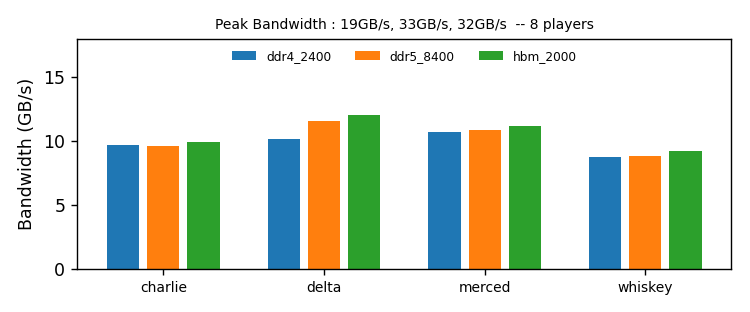

In [69]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('8p', '0', '0', '0', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=18)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
plt.title('Peak Bandwidth : 19GB/s, 33GB/s, 32GB/s  -- 8 players', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


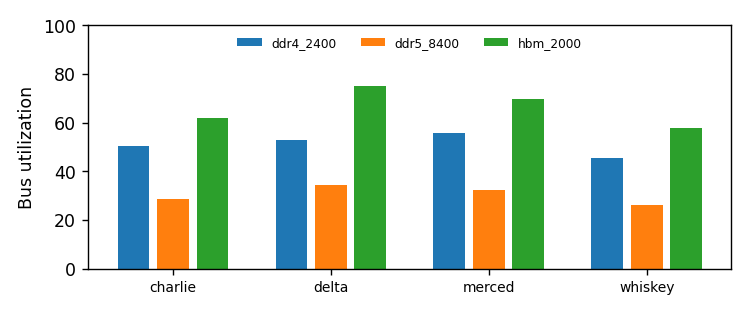

In [70]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('8p', '0', '0', '0', 'busUtil')

plt.ylabel('Bus utilization')
plt.ylim(ymax=100)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
#plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- DDR4 --- inj : 60GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


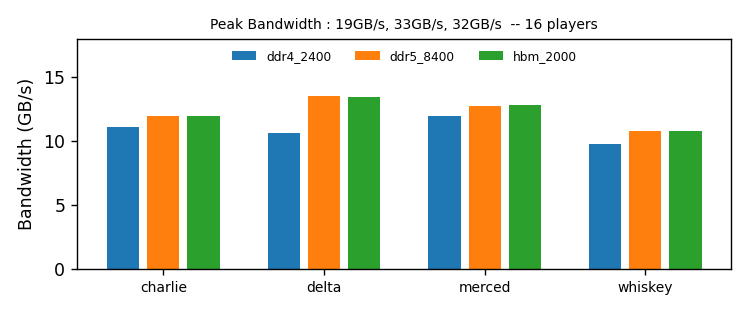

In [71]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('16p', '0', '0', '0', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=18)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
plt.title('Peak Bandwidth : 19GB/s, 33GB/s, 32GB/s  -- 16 players', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


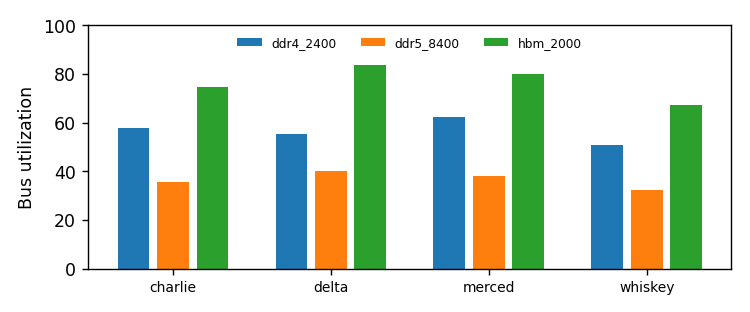

In [72]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('16p', '0', '0', '0', 'busUtil')

plt.ylabel('Bus utilization')
plt.ylim(ymax=100)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
#plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- DDR4 --- inj : 60GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")